# Import Module

In [1]:
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore') 
# import warnings;warnings.filterwarnings('ignore') 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set()
# import tushare as ts 
# from WindPy import w;w.start() 
import math
# import talib as ta
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tqdm import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb 
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
import tushare as ts
pro = ts.pro_api('00cd2bab356104dc83c866d0fc39c3c2b2b5b6c016435676304ad62f')

# Import Data

## Tech Factor

### Williams

In [3]:
def WR(data, N1, N2):
    
    
    
    
    data['WR10'] = 100 * (data['high'].rolling(N1).max() - data['close']) / (data['high'].rolling(N1).max() - data['low'].rolling(N1).min())
    data['WR6'] = 100 * (data['high'].rolling(N2).max() - data['close']) / (data['high'].rolling(N2).max() - data['low'].rolling(N2).min())
    
    data['WR10'].fillna(value=100 * (data['high'].expanding().max() - data['close']) / (data['high'].expanding().max() - data['low'].expanding().min()), inplace=True)
    data['WR6'].fillna(value=100 * (data['high'].expanding().max() - data['close']) / (data['high'].expanding().max() - data['low'].expanding().min()), inplace=True)

    return data

### MACD

In [4]:
def MACD(data):

    '''计算MACD指标
        输入参数：symbol <- str      标的代码 （2005年以前上市的不可用）
                start_time <- str  起始时间
                end_time <- str    结束时间
        输出数据：
                macd <- dataframe  macd指标，包括DIFF、DEA、MACD
    '''
    
    # 计算EMA(12)和EMA(16)
    data['EMA12'] = data['close'].ewm(alpha=2 / 13, adjust=False).mean()
    data['EMA26'] = data['close'].ewm(alpha=2 / 27, adjust=False).mean()

    # 计算DIFF、DEA、MACD
    data['DIFF'] = data['EMA12'] - data['EMA26']
    data['DEA'] = data['DIFF'].ewm(alpha=2 / 10, adjust=False).mean()
    data['MACD'] = 2 * (data['DIFF'] - data['DEA'])

    # 上市首日，DIFF、DEA、MACD均为0
    data['DIFF'].iloc[0] = 0
    data['DEA'].iloc[0] = 0
    data['MACD'].iloc[0] = 0

    return data

### RSI

In [5]:
def RSI(data, N1, N2, N3):
    
    
    
    
    data['change'] = data['close'] - data['pre_close']          
    data.loc[(data['pre_close'] == 0), 'change'] = 0            
    data['x'] = data['change'].apply(lambda x: max(x, 0))       
    data['RSI6'] = data['x'].ewm(alpha=1 / N1, adjust=False).mean() / (np.abs(data['change']).ewm(alpha=1/N1, adjust=False).mean()) * 100
    data['RSI12'] = data['x'].ewm(alpha=1 / N2, adjust=False).mean() / (np.abs(data['change']).ewm(alpha=1 / N2, adjust=False).mean()) * 100
    data['RSI24'] = data['x'].ewm(alpha=1 / N3, adjust=False).mean() / (np.abs(data['change']).ewm(alpha=1 / N3, adjust=False).mean()) * 100
    del data['x']
    
    return data

### KDJ

In [6]:
def KDJ(data, N, M1, M2):
    
    
    
    lowList = data['low'].rolling(N).min()
    lowList.fillna(value=data['low'].expanding().min(), inplace=True)
    highList = data['high'].rolling(N).max()
    highList.fillna(value=data['high'].expanding().max(), inplace=True)
    
    rsv = (data['close'] - lowList) / (highList - lowList) * 100
    
    data['kdj_k'] = rsv.ewm(alpha=1/M1, adjust=False).mean()     
    data['kdj_d'] = data['kdj_k'].ewm(alpha=1/M2, adjust=False).mean()
    data['kdj_j'] = 3.0 * data['kdj_k'] - 2.0 * data['kdj_d']
    
    return data

### DMA

In [7]:
def DMA(data, N1, N2, M):
    
    
    
    data['MA10'] = data['close'].rolling(N1).mean()
    data['MA50'] = data['close'].rolling(N2).mean()
    data['DIF'] = data['MA10'] - data['MA50']
    data['AMA'] = data['DIF'].rolling(M).mean()
    
    return data

### Bias

In [8]:
def BIAS(data, N1, N2, N3):
    
    
    
    
    data['BIAS6'] = (data['close'] - data['close'].rolling(N1).mean())/data['close'].rolling(N1).mean() * 100
    data['BIAS12'] = (data['close'] - data['close'].rolling(N2).mean())/data['close'].rolling(N2).mean() * 100
    data['BIAS24'] = (data['close'] - data['close'].rolling(N3).mean())/data['close'].rolling(N3).mean() * 100
    
    return data

In [9]:
hq = pd.read_csv('hq.csv',index_col=0)

In [10]:
hq['date'] = hq['date'].apply(lambda x:x[:4]+x[5:7]+x[8:10])

In [11]:
hq.head()

,date,code,ret,pre_close,open,high,low,close,vol,amount,change_price
9848,20100104,002065.SZ,0.030551,23.24,23.32,24.10,22.83,23.95,22003.13,51395.1348,0.71
4517,20100104,002271.SZ,0.060636,49.97,50.80,54.97,50.38,53.00,35373.92,188721.7539,3.03
4512,20100104,002244.SZ,-0.033172,14.47,14.40,14.49,13.94,13.99,102483.59,144208.4907,-0.48
4508,20100104,000539.SZ,-0.012771,7.83,7.84,7.87,7.73,7.73,71759.04,55714.7828,-0.10
4506,20100104,000527.SZ,-0.035776,23.20,23.06,23.06,22.00,22.37,151199.80,339660.7406,-0.83


In [12]:
hq.columns

Index(['date', 'code', 'ret', 'pre_close', 'open', 'high', 'low', 'close',
       'vol', 'amount', 'change_price'],
      dtype='object')

In [13]:
codelis = hq.code.unique().tolist()

In [21]:
caiwu = pd.read_csv('caiwu_1.csv',index_col=0)

In [17]:
caiwu['date'] = caiwu['date'].apply(lambda x:x[:4]+x[5:7]+x[8:10])

In [18]:
caiwu.head()

,code,date,S_DFA_OR_TTM,S_DFA_GROSSMARGIN_TTM,S_DFA_OPERATEINCOME_TTM,S_DFA_INVESTINCOME_TTM,S_DFA_OP_TTM,S_DFA_EBT_TTM,S_DFA_PROFIT_TTM,S_DFA_NETPROFIT_TTM,...,S_DFA_TTMGROWRATE_PROFIT,S_DFA_TTMGROWRATE_OP,S_DFA_TTMGROWRATE_GM,S_DFA_NAT_TTM,S_DFA_ROA_TTM,S_DFA_PROFITTOMV_AVG5Y,S_DFA_ROA_TTM_AVG5Y,S_DFA_ROE_TTM_AVG5Y,S_DFA_BERRYRATIO_TTM,S_DFA_CASHRECOVERYRATIO
88156,600811.SH,20100101,1.285594e+09,3.701396e+08,-3.720682e+08,8.268063e+08,4.547381e+08,4.481760e+08,4.163483e+08,4.364392e+08,...,355.6967,251.3249,52.3099,0.2649,4.9776,16.6628,1.7002,3.2808,56.5289,-9.9209
367482,000839.SZ,20100101,1.507724e+09,5.348040e+08,3.639376e+06,8.354351e+08,8.390745e+08,8.750204e+08,7.345031e+08,7.365019e+08,...,98.6701,114.4746,-8.6818,0.2723,6.3509,2.2812,3.8551,7.9948,126.2683,-2.0976
39558,600309.SH,20100101,6.186313e+09,1.684701e+09,9.326982e+08,1.545269e+07,9.481509e+08,1.406439e+09,1.393018e+09,1.164062e+09,...,-24.6902,-56.6029,-26.1600,1.1646,15.7463,1.8153,20.4415,38.8008,235.8472,20.8087
234677,000581.SZ,20100101,2.632101e+09,4.848754e+08,-6.430086e+07,3.562424e+08,2.919416e+08,2.793726e+08,2.717989e+08,2.580165e+08,...,-7.7468,-6.1371,-2.1538,0.9475,5.4174,2.1047,4.8547,8.6753,114.1064,8.7422
325958,000900.SZ,20100101,1.645511e+09,9.321736e+08,8.659119e+08,1.122769e+06,8.670347e+08,8.436200e+08,6.263758e+08,6.280018e+08,...,2.8718,4.1715,-10.5714,0.4714,11.8419,1.8434,6.5422,11.7942,-1867.7343,17.3261


In [20]:
df['month'] = df['date'].apply(str).apply(lambda x:x[:6])

KeyError: 'date'

In [28]:
caiwu['month'] = caiwu['date'].apply(str).apply(lambda x:x[:6])

In [28]:
all_df = pd.merge(df,caiwu,on=['code','month'],how='left')

In [31]:
all_df.drop_duplicates(subset=['code','date'],keep='first',inplace = True)

In [33]:
for i in all_df.columns[1:]:
    all_df[i] = all_df.groupby('code')[i].bfill().ffill()

In [34]:
all_df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,...,grossprofit_margin,roe_waa,roe_dt,roa,roe_yearly,eqt_to_talcapital,ocf_to_debt,roa_yearly,roa_dp,end_date
0,000671.SZ,20100329,33.51,34.68,33.33,34.04,33.71,0.33,0.9800,26286.98,...,13.2547,1.34,1.3375,0.7470,5.3568,39.7208,-0.0332,1.3308,0.3396,20100331.0
1,000671.SZ,20100330,33.90,35.59,33.72,35.25,34.04,1.21,3.5500,32235.20,...,13.2547,1.34,1.3375,0.7470,5.3568,39.7208,-0.0332,1.3308,0.3396,20100331.0
2,000671.SZ,20100331,35.50,36.46,35.30,35.58,35.25,0.33,0.9400,25726.49,...,13.2547,1.34,1.3375,0.7470,5.3568,39.7208,-0.0332,1.3308,0.3396,20100331.0
3,000671.SZ,20100401,35.45,36.34,35.41,35.78,35.58,0.20,0.5600,25274.19,...,20.0020,9.58,9.2449,3.4091,18.3844,37.6034,-0.3310,4.6960,2.3673,20100630.0
4,000671.SZ,20100402,36.06,36.60,35.78,36.43,35.78,0.65,1.8200,21993.56,...,20.0020,9.58,9.2449,3.4091,18.3844,37.6034,-0.3310,4.6960,2.3673,20100630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776251,601868.SH,20211227,2.85,2.92,2.82,2.84,2.87,-0.03,-1.0453,6597811.74,...,90.0109,2.67,2.4987,2.5444,10.2292,99.9411,-0.0245,1.3680,0.3416,20210331.0
776252,601868.SH,20211228,2.82,2.83,2.70,2.73,2.84,-0.11,-3.8732,8146464.54,...,90.0109,2.67,2.4987,2.5444,10.2292,99.9411,-0.0245,1.3680,0.3416,20210331.0
776253,601868.SH,20211229,2.72,2.76,2.70,2.72,2.73,-0.01,-0.3663,3754503.03,...,90.0109,2.67,2.4987,2.5444,10.2292,99.9411,-0.0245,1.3680,0.3416,20210331.0
776254,601868.SH,20211230,2.70,2.74,2.67,2.70,2.72,-0.02,-0.7353,3961365.12,...,90.0109,2.67,2.4987,2.5444,10.2292,99.9411,-0.0245,1.3680,0.3416,20210331.0


### Sector Data

In [35]:

# from WindPy import w
# w.start()

In [36]:
# industry_sw = dict()
# for c in tqdm(com_lis):
#     industry_sw[c] = w.wss(c,"industry_sw_2021","tradeDate=20220311;industryType=1").Data[0][0]

In [38]:
# industry_sw = pd.DataFrame(industry_sw, index = ['industry']).T
# industry_sw.reset_index(inplace = True)
# industry_sw.rename(columns = {'index':'ts_code'},inplace = True)

In [39]:
# industry_sw

In [40]:
# industry_sw.to_csv('hy_sw.csv', encoding="gbk") # encoding="gbk" 
# # industry_classify.to_csv('hy_sw.csv', encoding="gbk",index=False)  

In [41]:
industry_sw = pd.read_csv('hy_sw.csv', encoding="gbk", index_col = 0)

In [43]:
# industry_sw

In [44]:
df = pd.merge(all_df,industry_sw,on='code',how='inner')

In [45]:
df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,...,roe_waa,roe_dt,roa,roe_yearly,eqt_to_talcapital,ocf_to_debt,roa_yearly,roa_dp,end_date,industry
0,000671.SZ,20100329,33.51,34.68,33.33,34.04,33.71,0.33,0.9800,26286.98,...,1.34,1.3375,0.7470,5.3568,39.7208,-0.0332,1.3308,0.3396,20100331.0,房地产
1,000671.SZ,20100330,33.90,35.59,33.72,35.25,34.04,1.21,3.5500,32235.20,...,1.34,1.3375,0.7470,5.3568,39.7208,-0.0332,1.3308,0.3396,20100331.0,房地产
2,000671.SZ,20100331,35.50,36.46,35.30,35.58,35.25,0.33,0.9400,25726.49,...,1.34,1.3375,0.7470,5.3568,39.7208,-0.0332,1.3308,0.3396,20100331.0,房地产
3,000671.SZ,20100401,35.45,36.34,35.41,35.78,35.58,0.20,0.5600,25274.19,...,9.58,9.2449,3.4091,18.3844,37.6034,-0.3310,4.6960,2.3673,20100630.0,房地产
4,000671.SZ,20100402,36.06,36.60,35.78,36.43,35.78,0.65,1.8200,21993.56,...,9.58,9.2449,3.4091,18.3844,37.6034,-0.3310,4.6960,2.3673,20100630.0,房地产
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760417,601868.SH,20211227,2.85,2.92,2.82,2.84,2.87,-0.03,-1.0453,6597811.74,...,2.67,2.4987,2.5444,10.2292,99.9411,-0.0245,1.3680,0.3416,20210331.0,建筑装饰
760418,601868.SH,20211228,2.82,2.83,2.70,2.73,2.84,-0.11,-3.8732,8146464.54,...,2.67,2.4987,2.5444,10.2292,99.9411,-0.0245,1.3680,0.3416,20210331.0,建筑装饰
760419,601868.SH,20211229,2.72,2.76,2.70,2.72,2.73,-0.01,-0.3663,3754503.03,...,2.67,2.4987,2.5444,10.2292,99.9411,-0.0245,1.3680,0.3416,20210331.0,建筑装饰
760420,601868.SH,20211230,2.70,2.74,2.67,2.70,2.72,-0.02,-0.7353,3961365.12,...,2.67,2.4987,2.5444,10.2292,99.9411,-0.0245,1.3680,0.3416,20210331.0,建筑装饰


In [48]:
# df.to_csv('pre_hy_qx_data_all.csv',encoding = 'gbk')

### Building sector factors

In [47]:

amount_hy = df.groupby(['industry','date'],as_index=False)['amount'].sum()

In [49]:

amount_hy.columns = ['industry','date','amount_hy']

In [51]:

df = pd.merge(df,amount_hy,on=['industry','trade_date'],how='inner')

In [52]:

df['s_m_size'] = df['s_m']*df['amount']/df['amount_hy']
df['close_size'] = df['close']*df['amount']/df['amount_hy']
df['dt_eps_size'] = df['dt_eps']*df['amount']/df['amount_hy']
df['roe_size'] = df['roe']*df['amount']/df['amount_hy']
df['current_ratio_size'] = df['current_ratio']*df['amount']/df['amount_hy']

In [53]:

industry_fea = df.groupby(['industry','trade_date'],as_index=False)[['s_m_size',
                                                                     'close_size',
                                                                     'dt_eps_size',
                                                                     'roe_size',
                                                                     'current_ratio_size',
                                                                     'amount_hy']].mean()

In [54]:
# industry_fea

In [55]:

industry_fea.columns = ['industry',
                        'trade_date',
                        'industry_mom',
                        'industry_close',
                        'industry_PE',
                        'industry_roe',
                        'industry_leverage',
                        'industry_size']

In [56]:

df = pd.merge(df,industry_fea,on=['industry','trade_date'],how='inner')

In [57]:

df = df.drop(['s_m_size',
              'close_size',
              'dt_eps_size',
              'roe_size',
              'current_ratio_size',
              'amount_hy'],axis=1) 

In [61]:
df['trade_date'] = df['trade_date'].astype(str)

## Emotional factors

In [63]:
psy = pd.read_csv('data.csv',index_col=0)

In [64]:
psy.columns

Index(['date', 'code', 'or', 'grossprofit', 'profit', 'profit_margin',
       'growthrate_profit', 'debt2asset', '5年平均收益市值比', '5年平均资产回报率',
       '5年平均权益回报率', 'AR', 'BR', 'PSY', 'open', 'high', 'low', 'close', 'ret',
       'volume', '20日特诺雷比率', 'mom5', 'mom20', 'mom120', '过去一个月收益率排名/股票总数的比值',
       '当前股价除以过去1个月股价均值再减1', '当前股价除以过去3个月股价均值再减1', '当前股价除以过去1年的股价均值再减1',
       '相对离散指数', '阿隆指标', '股价偏度', '5日成交量EMA（手）', '26日成交量EMA（手）', '5日平均换手率',
       '20日平均换手率', '120日平均换手率'],
      dtype='object')

In [ ]:

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [65]:
psy.rename(columns={'5年平均收益市值比':'ETP5',
                    '5年平均资产回报率':'ROA5',
                    '5年平均权益回报率':'ROE5',
                    '20日特诺雷比率':'TreynorRatio20',
                    '相对离散指数':'RVI',
                    '阿隆指标':'Aroon',
                    '股价偏度':'Skewness',
                    '5日成交量EMA（手）':'VEMA5',
                    '26日成交量EMA（手）':'VEMA26',
                    '5日平均换手率':'VOL5',
                    '20日平均换手率':'VOL20',
                    '120日平均换手率':'VOL120'},inplace=True)

In [66]:
psy['trade_date'] = psy['date'].apply(lambda x:x[:4]+x[5:7]+x[8:10])

In [67]:
psy['ts_code'] = psy['code']

In [68]:

df = pd.merge(df,psy[['ts_code',
                      'trade_date',
                      'ETP5',
                      'ROA5',
                      'ROE5', 
                      'AR',
                      'BR', 
                      'PSY',
                      'TreynorRatio20',
                      'RVI',
                      'Aroon',
                      'Skewness',
                      'VEMA5',
                      'VEMA26',
                      'VOL5',
                      'VOL20',
                      'VOL120']],on=['ts_code','trade_date'],how='left')

In [69]:
df['ARBR'] = df['AR'] - df['BR']

In [73]:
df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,...,TreynorRatio20,RVI,Aroon,Skewness,VEMA5,VEMA26,VOL5,VOL20,VOL120,ARBR
0,000671.SZ,20100329,33.51,34.68,33.33,34.04,33.71,0.33,0.9800,26286.98,...,0.040827,0.392593,76.0,8.988540,3.856310e+06,3.794926e+06,0.047452,0.043907,0.031908,0.212981
1,600177.SH,20100329,15.70,16.39,15.62,16.21,15.57,0.64,4.1100,536868.47,...,0.006395,0.662338,40.0,14.935437,3.287188e+07,2.213907e+07,0.021392,0.014433,0.013342,-0.042317
2,000002.SZ,20100329,9.33,9.58,9.32,9.54,9.30,0.24,2.5800,845597.42,...,0.001832,0.807692,36.0,-2.425646,6.725289e+07,6.962187e+07,0.006395,0.007203,0.013249,-0.153523
3,000069.SZ,20100329,15.24,15.86,15.17,15.79,15.17,0.62,4.0900,309915.16,...,0.003459,0.797101,64.0,0.803749,2.213908e+07,2.192812e+07,0.015131,0.016447,0.020036,-0.045967
4,600383.SH,20100329,13.85,14.31,13.70,14.22,13.78,0.44,3.1900,830777.16,...,0.012924,0.606557,92.0,-13.002490,5.514924e+07,5.669036e+07,0.021018,0.029541,0.031713,-0.089486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760417,300888.SZ,20211227,81.40,82.48,79.91,80.10,81.40,-1.30,-1.5971,12247.42,...,-0.013179,-0.505837,-52.0,12.822858,1.438602e+06,1.653319e+06,0.010388,0.011708,0.028053,-0.454906
760418,300888.SZ,20211228,80.55,81.34,80.10,80.27,80.10,0.17,0.2122,8973.23,...,-0.013909,-0.225806,-52.0,2.468163,1.258176e+06,1.597319e+06,0.010340,0.010941,0.027706,-0.440530
760419,300888.SZ,20211229,80.47,82.60,79.51,82.08,80.27,1.81,2.2549,18401.24,...,-0.007861,0.521036,-52.0,-0.435804,1.452158e+06,1.615305e+06,0.011765,0.010778,0.027444,-0.506952
760420,300888.SZ,20211230,81.93,82.14,81.23,81.78,82.08,-0.30,-0.3655,14202.79,...,-0.002920,-0.164835,-52.0,0.262372,1.441532e+06,1.600859e+06,0.010121,0.010718,0.027225,-0.477609


In [74]:
df.columns

Index(['ts_code', 'trade_date', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'vol', 'amount', 'ret', 'next_ret', 'change_price',
       'mark', 'WR10', 'WR6', 'RSI6', 'RSI12', 'RSI24', 'BIAS6', 'BIAS12',
       'BIAS24', 'MA10', 'MA50', 'EMA12', 'EMA26', 'MACD', 'volume_5_std',
       'volume_5', 's_m', 'm_m', 'l_m', 's_v', 'REV_LAST1M_MAX', 'm_v', 'l_v',
       'AD', 'TRANGE', 'ATR', 'DMA', 'KDJ', 'month', 'eps', 'roe', 'roic',
       'current_ratio', 'dt_eps', 'revenue_ps', 'netprofit_margin',
       'debt_to_assets', 'op_yoy', 'roe_yoy', 'or_yoy', 'grossprofit_margin',
       'roe_waa', 'roe_dt', 'roa', 'roe_yearly', 'eqt_to_talcapital',
       'ocf_to_debt', 'roa_yearly', 'roa_dp', 'end_date', 'industry',
       'industry_mom', 'industry_close', 'industry_PE', 'industry_roe',
       'industry_leverage', 'industry_size', 'ETP5', 'ROA5', 'ROE5', 'AR',
       'BR', 'PSY', 'TreynorRatio20', 'RVI', 'Aroon', 'Skewness', 'VEMA5',
       'VEMA26', 'VOL5', 'VOL20

In [75]:
# df.columns[0]

In [76]:

for i in df.columns[1:]:
    df[i] = df.groupby('ts_code')[i].bfill().ffill()

In [78]:
df = df.dropna()

In [ ]:
# df_describe = df.describe().T

In [ ]:
# df_describe

In [ ]:
# df_describe.index

In [ ]:

# df_describe = df_describe.drop(['mark','end_date'])

In [ ]:

# df_describe.to_csv('factor_describe_raw.csv')

In [ ]:
# df

In [85]:
df_linear = df.copy()

In [86]:
fea_names = [i for i in df_linear.columns if i not in ['industry','ts_code','trade_date','mark','end_date','month','pct_chg','ret','next_ret']]

In [87]:

# def winsorize(factor,p,data):  
#     data = data.sort_values(factor)    #按factor排序 从小到大
#     data['rank'] = range(len(data))    
#     #down_limit,upper_limit = round(len(data)*p),round(len(data)*(1-p))  #去极值处理的分位点
#     data.loc[:round(len(data)*p),factor] = list(data[factor])[round(len(data)*p)]  #winsorize是用相应分位数的值替代分位数之外的值，而不是删掉
#     data.loc[round(len(data)*(1-p)):,factor] = list(data[factor])[round(len(data)*(1-p))]
#     return data

In [88]:
for fea in tqdm(fea_names):
    # print(fea,df[fea].mean(),df[fea].std())
    df_linear[fea] = np.where(df_linear[fea]>df_linear[fea].mean()+3*df_linear[fea].std(),df_linear[fea].mean()+3*df_linear[fea].std(), df_linear[fea])
    df_linear[fea] = np.where(df_linear[fea]<df_linear[fea].mean()-3*df_linear[fea].std(),df_linear[fea].mean()-3*df_linear[fea].std(), df_linear[fea])
#     df = winsorize(fea,0.01,df)

100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:09<00:00,  7.88it/s]


In [91]:
# df_describe = df_linear.describe().T

In [92]:
# df_describe.index

In [93]:

# df_describe = df_describe.drop(['mark','end_date'])

# df_describe.to_csv('factor_describe_qujizhihou.csv')

In [94]:
# # df.info()

In [95]:
fea_names = [i for i in df_linear.columns if i not in ['industry','ts_code','trade_date','mark','end_date','month','rank','pct_chg','ret','next_ret']]

In [96]:
for fea in fea_names:
    # print(fea,df[fea].mean(),df[fea].std())
    df_linear[fea] = (df_linear[fea]-df_linear[fea].mean())/df_linear[fea].std()

In [97]:

# df_describe = df.describe().T

# df_describe = df_describe.drop(['mark','end_date'])

# df_describe.to_csv('factor_describe_final.csv')

In [98]:

# df_linear.to_csv('standard_data_all.csv',encoding = 'gbk')

In [102]:

idx_lis = df_linear.industry.unique().tolist()

In [103]:
d1 = df_linear.set_index('trade_date')

In [104]:

def test_ic(code,df,rank=False):
    
    df1 = df[df.industry==code] 
    df1.index = pd.to_datetime(df1.index.astype(str))
    df1['next_ret'] = df1.groupby('ts_code')['pct_chg'].shift(-1)
    df2 = df1.resample('W').mean()
    factor = [i for i in df2.columns if i not in ['pct_chg','ret','next_ret','mark','end_date','month']]
    df2 = df2.bfill().ffill().fillna(0)    
    ic_dic = {}
    for fac in factor:
        if rank:
            ic_dic[fac] = df2[fac].rank().corr(df2['next_ret'].rank())
        else:
            ic_dic[fac] = df2[fac].corr(df2['next_ret'])
            
    return ic_dic

In [105]:
stocklis = d1.ts_code.unique().tolist()

In [106]:

def load_allstock_factor(stocklis,df):
    all_ic_df = pd.DataFrame()
    for code in tqdm(stocklis):
        dic = test_ic(code,df)
        single_df = pd.DataFrame(dic,index=[code]).T
        all_ic_df = pd.concat([all_ic_df,single_df],axis=1)
    return all_ic_df

In [107]:

ic_val = load_allstock_factor(idx_lis,d1)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.52it/s]


In [108]:

ic_val

,房地产,医药生物,汽车,国防军工,食品饮料,交通运输,有色金属,商业贸易,非银金融,银行,...,建筑建材,钢铁,传媒,公用事业,采掘,建筑材料,农林牧渔,休闲服务,轻工制造,纺织服装
open,-0.068051,-0.014122,-0.000802,-0.047642,-0.018742,-0.025213,-0.010639,-0.062704,-0.043959,-0.098428,...,-7.605440e-02,0.005707,0.046157,-0.047988,-0.073362,0.023775,-0.017389,-0.027059,-0.006048,-0.085668
high,-0.053690,-0.009396,0.004741,-0.040190,-0.014374,-0.021275,-0.000245,-0.051321,-0.025839,-0.078176,...,-6.113399e-02,0.020569,0.052951,-0.034085,-0.064284,0.030070,-0.007978,-0.022221,-0.000904,-0.059739
low,-0.054798,-0.007836,0.004518,-0.035362,-0.012824,-0.017996,-0.004557,-0.051881,-0.034820,-0.089777,...,-6.464627e-02,0.015922,0.055986,-0.035841,-0.062157,0.030336,-0.011003,-0.024676,-0.000587,-0.060027
close,-0.044799,-0.003888,0.008863,-0.027937,-0.009645,-0.014062,0.005262,-0.043330,-0.018413,-0.072893,...,-5.342487e-02,0.029078,0.062635,-0.024512,-0.053914,0.034660,-0.003182,-0.020317,0.003647,-0.038451
pre_close,-0.073416,-0.016055,-0.003681,-0.052814,-0.019968,-0.029737,-0.016331,-0.067605,-0.049363,-0.103763,...,-8.004309e-02,0.003675,0.038590,-0.051170,-0.081510,0.021591,-0.020273,-0.030042,-0.007931,-0.086854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VEMA26,0.022052,-0.009618,-0.020817,0.018123,-0.033207,-0.000932,0.023042,0.024970,0.039633,0.015766,...,-2.743438e-02,-0.013859,-0.050207,0.019854,-0.018777,-0.093582,0.020519,-0.014970,-0.067387,0.132861
VOL5,0.013690,0.046451,-0.006800,0.045683,0.005153,-0.003991,0.067688,0.032193,0.084497,0.041958,...,-7.549684e-18,0.034707,0.105433,0.011446,0.024320,0.006907,0.036306,0.021985,-0.043522,0.024532
VOL20,-0.034353,-0.011967,-0.045620,0.002777,-0.032866,-0.033662,-0.022733,0.015131,0.026132,-0.015332,...,NaN,-0.033832,0.078189,0.002020,0.011509,-0.037591,-0.023072,0.032970,-0.064408,-0.030301
VOL120,-0.027185,-0.015187,-0.026319,0.007904,-0.045390,-0.014500,-0.025812,-0.014823,0.004868,-0.038032,...,7.549684e-18,-0.060735,0.091095,-0.028306,0.015853,0.008744,-0.027908,-0.001631,0.008842,-0.018214


In [109]:

sig = abs(ic_val.mean(1)).dropna()

In [110]:
sig.sort_values(ascending=False)

change          0.636505
RVI             0.611094
BIAS6           0.472364
WR6             0.425585
WR10            0.351580
                  ...   
change_price    0.001054
l_v             0.000713
AD              0.000238
ETP5            0.000185
dt_eps          0.000122
Length: 78, dtype: float64

In [203]:

industry_IC = sig.sort_values(ascending=False)
# industry_IC.to_csv('industry_IC.csv')

In [204]:
industry_IC

change          0.636505
RVI             0.611094
BIAS6           0.472364
WR6             0.425585
WR10            0.351580
                  ...   
change_price    0.001054
l_v             0.000713
AD              0.000238
ETP5            0.000185
dt_eps          0.000122
Length: 78, dtype: float64

In [113]:
# len(industry_IC)

In [114]:

feanames = [i for i in df_linear.columns if i not in ['industry','ts_code','trade_date','pct_chg','ret','next_ret','mark','end_date']]

In [115]:

def test_ic_TimeSeries(factor,df,rank=False,num=20):
    print('Factor:',factor)
    df1 = df[[factor,'next_ret','trade_date']]
    # df1.index = pd.to_datetime(df1.index.astype(str))
    # df2 = df1.resample('W').mean()
    ic_dic = {}
    ic_df = df1.groupby('trade_date')[[factor,'next_ret']].mean()
    for i in range(num, ic_df.shape[0],num):
        test = ic_df.iloc[i-num:i]
        ic_dic[i-num] = test[factor].corr(test['next_ret'])
    ic_plot = pd.DataFrame(ic_dic,index=['cor']).T
    # ic_plot.index = df1.trade_date.unique()[num:]
    # ic_plot.index = pd.to_datetime(ic_plot.index)
    df = ic_plot.reset_index()
    # df.columns = ['trade_date', ids]
    df.set_index('index')['cor'].plot(figsize=(12,8),grid=True,title='IC Time Series Plot')

    model = sm.OLS(df1['next_ret'].values,df1[factor].values.reshape(-1,1))
    results = model.fit()
    print(results.summary())
    return 

Factor: dt_eps
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              22.15
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                    2.52e-06
Time:                        16:54:32   Log-Likelihood:                      1.6674e+06
No. Observations:              760422   AIC:                                 -3.335e+06
Df Residuals:                  760421   BIC:                                 -3.335e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

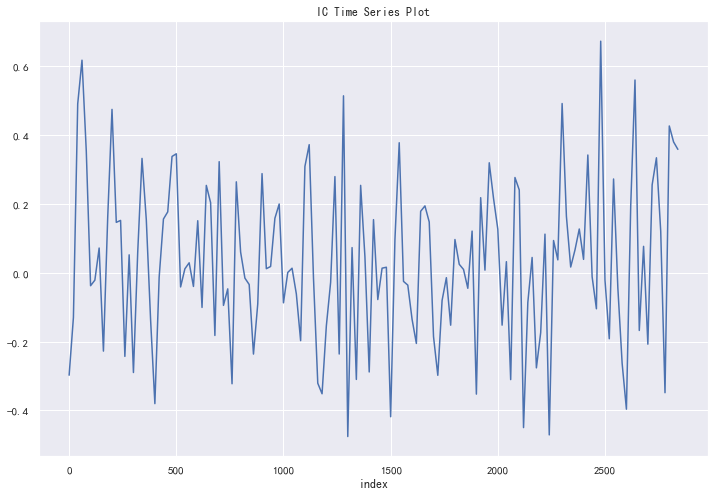

In [116]:
test_ic_TimeSeries('dt_eps',df_linear) #industry_mom

In [2]:
from scipy import stats, optimize

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(d1[feanames[0]])
plot_pacf(d1[feanames[0]])

In [117]:
def multifactor_for_stock(code,df):
    
    dt = df[df.ts_code == code]
    X_train = dt[feanames].values
    Y_train = dt['next_ret'].values
    model = LinearRegression()
    model.fit(X_train,Y_train)
    a  = model.intercept_
    b = model.coef_
    print("股票alpha:",a)
    tb = pd.DataFrame(b,index=feanames,columns=['factor_ret']) 
    print(tb)
    
    return tb

In [125]:
tb = multifactor_for_stock(stocklis[0],df_linear)

股票alpha: -1.4205567460512583
           factor_ret
open        -0.404451
high         0.181611
low          0.189089
close        0.027507
pre_close    0.027491
...               ...
VEMA26      -0.010530
VOL5        -0.003857
VOL20        0.002741
VOL120       0.000767
ARBR        -0.002002

[79 rows x 1 columns]


In [126]:
tb.sort_values(by = 'factor_ret',ascending = False,inplace = True)

In [129]:
choose_fac = sig.sort_values(ascending=False).index.tolist()[:60]

In [130]:

fea_names = choose_fac

In [131]:

corr_df = df_linear[fea_names].corr()

In [2]:
# Train:2018-01-01，Test:2018-01-01

In [132]:

d1['mark'] = np.sign(d1.groupby('ts_code')['pct_chg'].shift(-1))

In [133]:
df_ols = d1.reset_index()
df_ols['date'] = df_ols['trade_date'].apply(str).apply(lambda x:x[:10])

In [134]:
df_ols = df_ols.dropna()

In [135]:

df_ols = df_ols.dropna()
train_data_ols = df_ols[df_ols['date'] < time]
test_data_ols = df_ols[df_ols['date'] >= time]
# cost = 0.0003
X_train_ols = train_data_ols[fea_names]
X_test_ols = test_data_ols[fea_names]
y_train_ols = train_data_ols['mark']
y_test_ols = test_data_ols['mark']
test_data_ols['pct_chg'] = test_data_ols['pct_chg']/100

In [141]:

df['mark'] = np.sign(df.groupby('ts_code')['pct_chg'].shift(-1))

In [142]:
df['date'] = df['trade_date'].apply(str).apply(lambda x:x[:10])

In [143]:
df = df.dropna()

In [144]:

time = "20180101"
df = df.dropna()
train_data = df[df['date'] < time]
test_data = df[df['date'] >= time]
# cost = 0.0003
X_train = train_data[fea_names]
X_test = test_data[fea_names]
y_train = train_data['mark']
y_test = test_data['mark']
test_data['pct_chg'] = test_data['pct_chg']/100

### The prediction accuracy of the model was calculated

In [145]:
def model_evaluation(estimator, train_data, real_mark):
    predict = estimator.predict(train_data)
    compare_df = pd.DataFrame({'Real': real_mark, 'Predict': predict})
    compare_df['mark'] = ~np.logical_xor(compare_df.Predict, compare_df.Real)
    score = estimator.score(train_data, real_mark)
    print(f'Accuracy: {score}\n\nConfusion matrix:\n')
    confusion = confusion_matrix(real_mark, predict, labels=[0,1])
    confusion_df = pd.DataFrame(confusion, index=['0_real', '1_real'], columns=['0_predict', '1_predict'] )
    return confusion_df

In [146]:
clf_ols = LogisticRegression()
clf_ols.fit(X_train_ols, y_train_ols)
model_evaluation(clf_ols, X_train_ols, y_train_ols)

Accuracy: 0.5163623186122359

Confusion matrix:



,0_predict,1_predict
0_real,0,6804
1_real,0,131983


In [147]:
clf_forest = RandomForestClassifier(n_estimators=10, max_features='sqrt', max_depth=100, class_weight='balanced')
clf_forest.fit(X_train,y_train)
model_evaluation(clf_forest, X_train, y_train)

Accuracy: 0.9840372015134498

Confusion matrix:



,0_predict,1_predict
0_real,11839,295
1_real,26,214383


In [148]:
model_evaluation(clf_forest, X_test, y_test)

Accuracy: 0.4957249529744827

Confusion matrix:



,0_predict,1_predict
0_real,44,3750
1_real,128,63817


In [149]:
df['mark_xg'] = df['mark'].replace(-1,0)

In [150]:
y_train_xg = y_train.replace(-1,0)

In [151]:
y_test_xg = y_test.replace(-1,0)

In [152]:
data = df[fea_names] 


label = df['mark_xg']
dtrain = xgb.DMatrix(X_train, label = y_train_xg)
dtest = xgb.DMatrix(X_test)


params={'booster':'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth':4,
    'lambda':10,
    'subsample':0.75,
    'colsample_bytree':0.75,
    'min_child_weight':2,
    'eta': 0.025,
    'seed':0,
    'nthread':8,
     'silent':1}

watchlist = [(dtrain,'train')]

bst=xgb.train(params,dtrain,num_boost_round=100,evals=watchlist)
ypred=bst.predict(dtest)


y_pred = (ypred >= 0.3)*1


print ('AUC: %.4f' % metrics.roc_auc_score(y_test_xg,ypred))


print ('ACC: %.4f' % metrics.accuracy_score(y_test_xg,y_pred))
print ('Recall: %.4f' % metrics.recall_score(y_test_xg,y_pred))


print ('F1-score: %.4f' %metrics.f1_score(y_test_xg,y_pred))
print ('Precesion: %.4f' %metrics.precision_score(y_test_xg,y_pred))
confusion_matrix(y_test_xg,y_pred)

[17:12:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.54737
[1]	train-auc:0.55180
[2]	train-auc:0.55378
[3]	train-auc:0.55412
[4]	train-auc:0.55480
[5]	train-auc:0.55483
[6]	train-auc:0.55532
[7]	train-auc:0.55597
[8]	train-auc:0.55598
[9]	train-auc:0.55650
[10]	train-auc:0.55645
[11]	train-auc:0.55671
[12]	train-auc:0.55690
[13]	train-auc:0.55709
[14]	train-auc:0.55722
[15]	train-auc:0.55739
[16]	train-auc:0.55743
[17]	train-auc:0.55741
[18]	train-auc:0.55743
[19]	train-auc:0.55751
[20]	train-auc:0.55788
[21]	train-auc:0.55794
[22]	train-auc:0.55793
[23]	train-auc:0.55804
[24]	train-auc:0.55809
[25]	train-auc:0.558

array([[     0, 163845],
       [     0, 151941]], dtype=int64)

# The stock returns are predicted based on the model

In [156]:
predict = clf_forest.predict(X_test)
test_data['predict'] = predict

# Take a full position on bears and a full position on bulls
test_data['predict'] = np.where(test_data['predict'] <= 0 ,0.5,1)
test_data['rets'] = test_data['predict'].shift(1) * test_data['pct_chg']

In [157]:
test_data['predict_xg'] = y_pred
test_data['predict_xg'] = np.where(test_data['predict_xg'] <= 0 ,0.5,1)
test_data['rets_xg'] = test_data['predict_xg'].shift(1) * test_data['pct_chg']

In [158]:
predict_ols = clf_ols.predict(X_test_ols)
test_data['predict_ols'] = predict_ols
test_data['predict_ols'] = np.where(test_data['predict_ols'] <= 0 ,0.5,1)
test_data['rets_ols'] = test_data['predict_ols'].shift(1) * test_data['pct_chg']

In [160]:
test_data = test_data.dropna()

In [161]:
test_data['trade_date'] = test_data['trade_date'].astype(str)

In [162]:
ret_df = test_data.groupby('trade_date')[['rets_xg','rets','pct_chg','rets_ols']].mean()
# ret_df = test_data.groupby('trade_date')[['rets_xg','rets','pct_chg','rets_ols','rets_NB']].mean()
ret_df['benchmark'] = ret_df['pct_chg']
ret_df['OLS'] = ret_df['rets_ols'] + ret_df['pct_chg']
ret_df['RF'] = ret_df['rets'] + ret_df['pct_chg']
ret_df['XGBoost'] = ret_df['rets_xg'] + ret_df['pct_chg']
# ret_df['NB'] = ret_df['rets_NB'] + ret_df['pct_chg']

In [163]:
ret_df.index = pd.to_datetime(ret_df.index)

<AxesSubplot:xlabel='trade_date'>

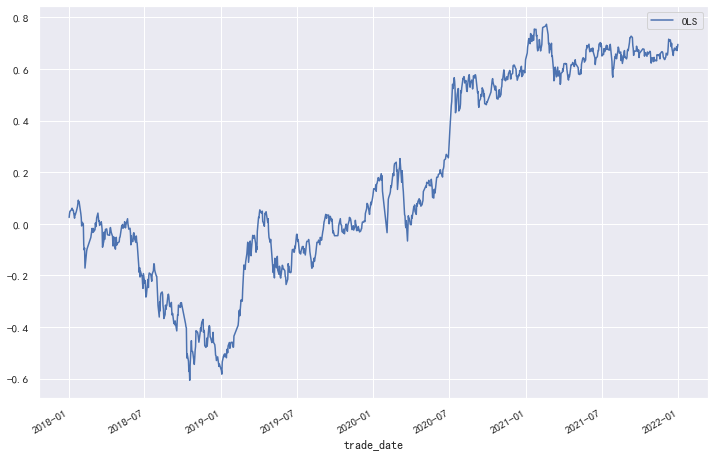

In [164]:
ret_df[['OLS']].cumsum().plot(figsize=(12,8),grid=True)

# HS300

In [1]:
#From tushare

In [166]:
hs300 = pd.read_csv('hs300.csv',index_col=0)
# hs300

In [167]:
ret_df['HS300'] = hs300['pct_chg'].values/100

<AxesSubplot:xlabel='trade_date'>

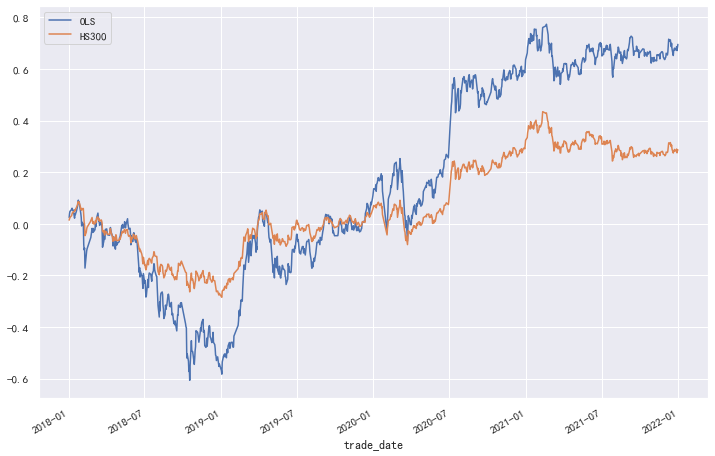

In [168]:
ret_df[['OLS','HS300']].cumsum().plot(figsize=(12,8),grid=True)

# set initial capital M

In [29]:
M = 10000000

In [ ]:
money_df = M*ret_df

<AxesSubplot:xlabel='trade_date'>

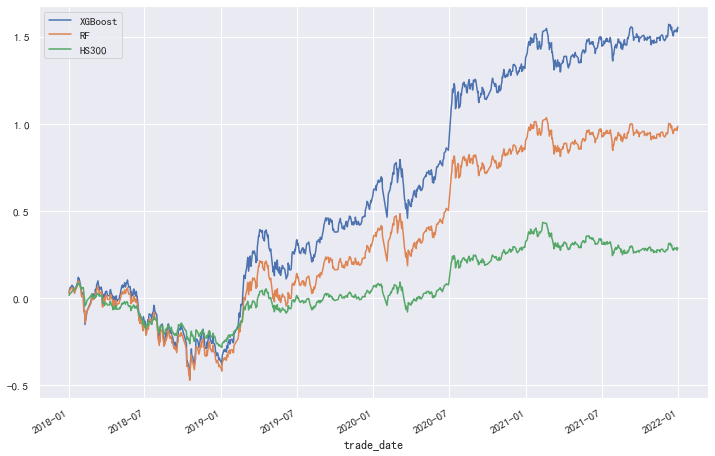

In [169]:
ret_df[['XGBoost','RF','HS300']].cumsum().plot(figsize=(12,8),grid=True)

<AxesSubplot:xlabel='trade_date'>

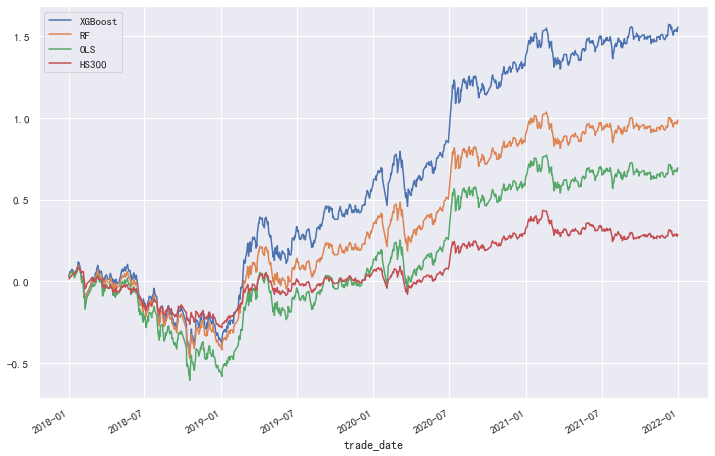

In [170]:
ret_df[['XGBoost','RF','OLS','HS300']].cumsum().plot(figsize=(12,8),grid=True)

In [ ]:
money_df[['XGBoost','RF','HS300']].cumsum().plot(figsize=(12,8),grid=True)

In [171]:
def ratio(data):
    
    strategy_cum = (data + 1).cumprod()
    return_year = data.mean() * 252 
    volatility = data.std() * 252 ** 0.5   #volatility = df['strategy'].std()/ (np.sqrt(1/252) )
    profit_max = data.max()
    loss_max = data.min()
    sharpe = (return_year - 0.02) / volatility 
    IC_ratio = (return_year - 0.03) / volatility
    
    tmp = pd.DataFrame([ float((strategy_cum).tail(1)), sharpe, return_year, volatility, profit_max, loss_max, IC_ratio], 
                       columns=[data.name], 
                       index=[ 'Total Return', 'Sharpe Ratio' , 'CAGR', 'Annualised Volatility', 'Maximum Daily Profit', 
                              'Maximum Daily Loss','IC Ratio'])
    tmp.columns = ['Performance']
#         res.append(tmp)

    return tmp

In [176]:
# ratio(ret_df['RF'])

In [177]:
# ratio(ret_df['HS300'])

In [178]:
# ratio(ret_df['XGBoost'])

In [179]:
# ratio(ret_df['OLS'])

In [180]:

look_XGBoost = ratio(ret_df['XGBoost'])
look_RF = ratio(ret_df['RF'])
look_OLS = ratio(ret_df['OLS'])
look_hs300 = ratio(ret_df['HS300'])
look_all = pd.concat((look_XGBoost,look_RF,look_OLS,look_hs300),axis = 1)

In [181]:

look_all.columns = ['XGBoost','RF','OLS','HS300']

In [182]:
look_all

,XGBoost,RF,OLS,HS300
Total Return,3.315155,2.060774,1.483319,1.225641
Sharpe Ratio,0.893370,0.639849,0.407664,0.261569
CAGR,0.403258,0.255702,0.180109,0.074264
Annualised Volatility,0.429003,0.368372,0.392748,0.207457
Maximum Daily Profit,0.115248,0.097691,0.095969,0.059477
Maximum Daily Loss,-0.163906,-0.144200,-0.161501,-0.078809
IC Ratio,0.870060,0.612702,0.382202,0.213367


In [183]:
num = 20
importances = clf_forest.feature_importances_ 
importances_df = pd.DataFrame([fea_names, importances], index=['Features', 'Importances']).T
importances_df.sort_values(by='Importances',ascending=False).head(num)

,Features,Importances
34,ATR,0.048629
35,open,0.029483
32,s_v,0.02254
54,VOL20,0.02117
8,industry_mom,0.020888
1,RVI,0.020642
16,Skewness,0.020387
6,s_m,0.02007
33,VOL5,0.019518
2,BIAS6,0.019457


<AxesSubplot:title={'center':'the importance of factors'}, xlabel='Features'>

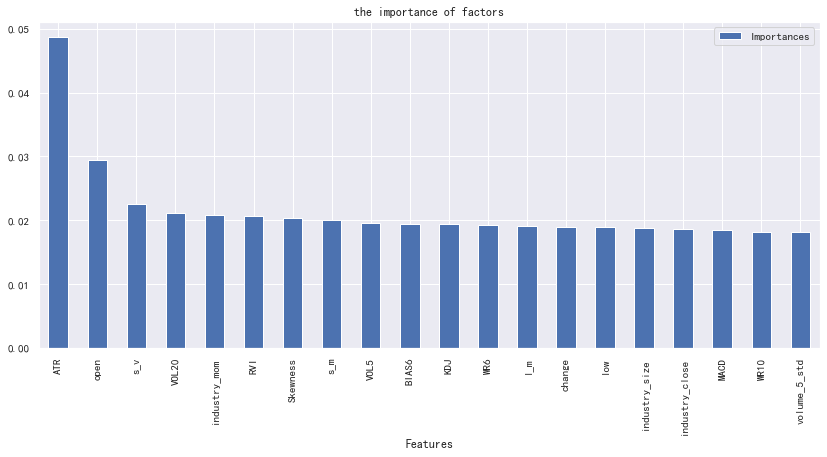

In [184]:
importances_df.set_index('Features').sort_values(by='Importances',ascending=False).head(num).plot.bar(figsize=(14,6),title='the importance of factors')

In [185]:
ip_lis = importances_df.set_index('Features').sort_values(by='Importances',ascending=False).head(num).index.tolist()

In [186]:
X_train[ip_lis].corr()

,ATR,open,s_v,VOL20,industry_mom,RVI,Skewness,s_m,VOL5,BIAS6,KDJ,WR6,l_m,change,low,industry_size,industry_close,MACD,WR10,volume_5_std
ATR,1.000000,0.806207,0.367363,0.353609,-0.013923,0.005746,-0.009536,-0.044697,0.326758,-0.067031,0.017410,-0.002107,0.176788,0.007278,0.799935,0.117915,0.243662,-0.176467,-0.004040,-0.102178
open,0.806207,1.000000,0.090257,0.136645,0.012500,-0.004958,0.003294,0.038429,0.127128,0.025336,0.069418,-0.033545,0.162424,0.028926,0.999688,0.040889,0.250052,0.005732,-0.050570,-0.138031
s_v,0.367363,0.090257,1.000000,0.358013,-0.043532,0.025878,0.035367,-0.204531,0.404202,-0.253943,0.001092,0.022216,0.066834,0.010737,0.084560,0.181532,0.069269,-0.213993,0.018776,0.130900
VOL20,0.353609,0.136645,0.358013,1.000000,0.022869,0.011196,-0.006304,0.021658,0.907073,-0.002913,0.038447,-0.001405,0.267338,-0.000217,0.132192,0.201124,0.081755,-0.038371,-0.015378,0.065979
industry_mom,-0.013923,0.012500,-0.043532,0.022869,1.000000,0.133248,0.142172,0.438161,0.068717,0.392983,0.316875,-0.348096,0.136595,0.132423,0.014460,0.046999,0.073826,0.174943,-0.345789,0.072229
RVI,0.005746,-0.004958,0.025878,0.011196,0.133248,1.000000,0.078798,0.271117,0.023485,0.408681,0.179681,-0.551263,0.070975,0.500883,0.004557,0.021421,0.021970,0.058743,-0.445484,0.019905
Skewness,-0.009536,0.003294,0.035367,-0.006304,0.142172,0.078798,1.000000,0.316684,0.070371,0.276224,0.258928,-0.224303,0.073792,0.091099,0.004389,0.035291,0.001810,0.158770,-0.247035,0.089641
s_m,-0.044697,0.038429,-0.204531,0.021658,0.438161,0.271117,0.316684,1.000000,0.135120,0.908852,0.626178,-0.698313,0.271884,0.291690,0.042189,0.086454,0.018955,0.480144,-0.688295,0.107975
VOL5,0.326758,0.127128,0.404202,0.907073,0.068717,0.023485,0.070371,0.135120,1.000000,0.074654,0.167255,-0.072441,0.268803,0.013438,0.122591,0.211171,0.077490,0.037707,-0.118696,0.113449
BIAS6,-0.067031,0.025336,-0.253943,-0.002913,0.392983,0.408681,0.276224,0.908852,0.074654,1.000000,0.519866,-0.729774,0.241674,0.415349,0.031323,0.073600,0.014324,0.418953,-0.679260,0.085542


In [187]:
def dataPlot():

    fig,ax=plt.subplots(figsize=(18,8))
    sns.heatmap(pd.DataFrame(np.round(X_train[ip_lis].corr(),4),columns=ip_lis,index=ip_lis),
                annot=True,
                vmax=1,
                vmin=0,
                xticklabels=True,
                yticklabels=True,
                square=True,
                cmap="YlGnBu")
    ax.set_title(' the importance of factors ', fontsize=18)
    ax.set_ylabel('Y', fontsize=16)
    ax.set_xlabel('X', fontsize=16)

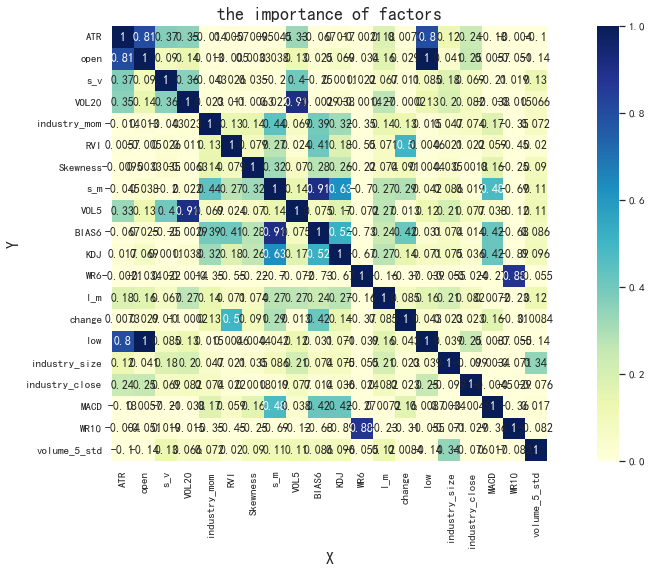

In [188]:
dataPlot()

In [189]:
importances_xg = bst.get_fscore()
importances_xg_df = pd.DataFrame([importances_xg], index=['Importances']).T
importances_xg_df.reset_index(inplace = True)
importances_xg_df.rename(columns={'index':'Features'},inplace=True)
importances_xg_df.sort_values(by='Importances',ascending=False).head(num)

,Features,Importances
3,WR6,176.0
1,RVI,125.0
4,WR10,91.0
32,s_v,81.0
2,BIAS6,75.0
29,industry_size,64.0
11,KDJ,62.0
53,industry_roe,56.0
0,change,52.0
5,RSI6,47.0


<AxesSubplot:title={'center':'the importance of factors'}, xlabel='Features'>

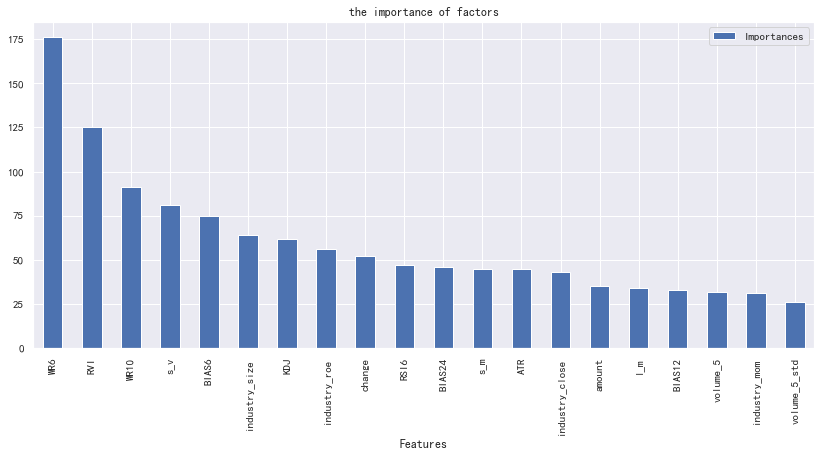

In [190]:

importances_xg_df.set_index('Features').sort_values(by='Importances',ascending=False).head(num).plot.bar(figsize=(14,6),title='the importance of factors')

In [191]:
ip_lis_xg = importances_xg_df.set_index('Features').sort_values(by='Importances',ascending=False).head(num).index.tolist()

In [192]:
X_train[ip_lis_xg].corr()

,WR6,RVI,WR10,s_v,BIAS6,industry_size,KDJ,industry_roe,change,RSI6,BIAS24,s_m,ATR,industry_close,amount,l_m,BIAS12,volume_5,industry_mom,volume_5_std
WR6,1.000000,-0.551263,0.881488,0.022216,-0.729774,-0.055398,-0.667378,0.007440,-0.368921,-0.802619,-0.475495,-0.698313,-0.002107,-0.024077,-0.090588,-0.164911,-0.638988,-0.031280,-0.348096,-0.054997
RVI,-0.551263,1.000000,-0.445484,0.025878,0.408681,0.021421,0.179681,0.025277,0.500883,0.422159,0.200548,0.271117,0.005746,0.021970,0.040815,0.070975,0.285535,0.006593,0.133248,0.019905
WR10,0.881488,-0.445484,1.000000,0.018776,-0.679260,-0.070650,-0.892069,0.009988,-0.311795,-0.887405,-0.610114,-0.688295,-0.004040,-0.029513,-0.109549,-0.226215,-0.740151,-0.054832,-0.345789,-0.082411
s_v,0.022216,0.025878,0.018776,1.000000,-0.253943,0.181532,0.001092,-0.010246,0.010737,0.054577,-0.154405,-0.204531,0.367363,0.069269,0.204884,0.066834,-0.225314,0.126856,-0.043532,0.130900
BIAS6,-0.729774,0.408681,-0.679260,-0.253943,1.000000,0.073600,0.519866,-0.005342,0.415349,0.666881,0.654732,0.908852,-0.067031,0.014324,0.118278,0.241674,0.859209,0.049577,0.392983,0.085542
industry_size,-0.055398,0.021421,-0.070650,0.181532,0.073600,1.000000,0.074882,-0.130823,0.023429,0.105449,0.124292,0.086454,0.117915,-0.098792,0.596184,0.209882,0.093945,0.400030,0.046999,0.340178
KDJ,-0.667378,0.179681,-0.892069,0.001092,0.519866,0.074882,1.000000,-0.013049,0.141506,0.849980,0.677739,0.626178,0.017410,0.036505,0.114395,0.273026,0.725814,0.075206,0.316875,0.095486
industry_roe,0.007440,0.025277,0.009988,-0.010246,-0.005342,-0.130823,-0.013049,1.000000,0.002748,-0.013098,-0.012840,-0.007182,0.016551,0.590129,-0.027593,-0.024247,-0.009494,-0.034209,0.007027,-0.030294
change,-0.368921,0.500883,-0.311795,0.010737,0.415349,0.023429,0.141506,0.002748,1.000000,0.308035,0.228087,0.291690,0.007278,0.022760,0.045906,0.084552,0.309118,-0.000366,0.132423,0.008378
RSI6,-0.802619,0.422159,-0.887405,0.054577,0.666881,0.105449,0.849980,-0.013098,0.308035,1.000000,0.692046,0.690019,0.027374,0.031310,0.151630,0.316529,0.737755,0.090511,0.358851,0.125259


Text(0.5, 49.625, 'X')

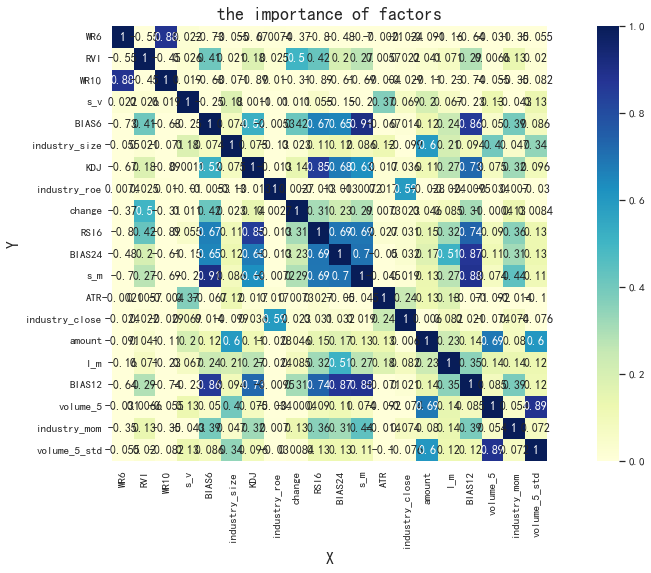

In [193]:
fig,ax=plt.subplots(figsize=(18,8))
sns.heatmap(pd.DataFrame(np.round(X_train[ip_lis_xg].corr(),4),columns=ip_lis_xg,index=ip_lis_xg),
            annot=True,
            vmax=1,
            vmin=0,
            xticklabels=True,
            yticklabels=True,
            square=True,
            cmap="YlGnBu")
ax.set_title(' the importance of factors ', fontsize=18)
ax.set_ylabel('Y', fontsize=16)
ax.set_xlabel('X', fontsize=16)

In [194]:
importances_ols = clf_ols.coef_[0]

In [195]:
importances_ols_df = pd.DataFrame(importances_ols,index = fea_names)
importances_ols_df.reset_index(inplace = True)
importances_ols_df.rename(columns={'index':'Features',0:'Importances'},inplace=True)

In [196]:
importances_ols_df.sort_values(by='Importances',ascending=False).head(20)

,Features,Importances
22,amount,0.205477
25,MA10,0.153722
5,RSI6,0.122068
28,EMA12,0.090421
31,pre_close,0.081922
26,REV_LAST1M_MAX,0.071749
36,volume_5,0.066899
49,close,0.060550
35,open,0.057284
24,EMA26,0.048848


In [197]:
ip_lis_ols = importances_ols_df.set_index('Features').sort_values(by='Importances',ascending=False).head(num).index.tolist()

Text(0.5, 49.625, 'X')

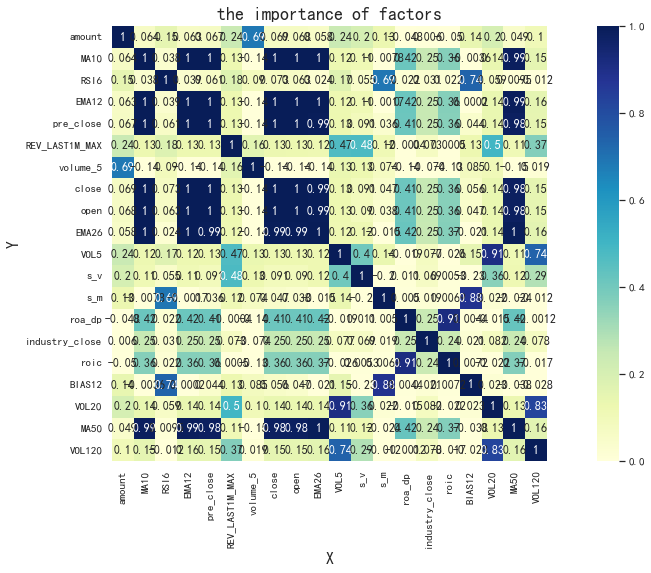

In [198]:
fig,ax=plt.subplots(figsize=(18,8))

sns.heatmap(pd.DataFrame(np.round(X_train[ip_lis_ols].corr(),4),columns=ip_lis_ols,index=ip_lis_ols),
            annot=True,
            vmax=1,
            vmin=0,
            xticklabels=True,
            yticklabels=True,
            square=True,
            cmap="YlGnBu")
ax.set_title(' the importance of factors ', fontsize=18)
ax.set_ylabel('Y', fontsize=16)
ax.set_xlabel('X', fontsize=16)

In [199]:
# from sklearn.inspection import permutation_importance
# imps = permutation_importance(NB, X_test, y_test)
# importances_NB = imps.importances_mean

In [200]:
# importances_NB_df = pd.DataFrame(importances_NB,index = fea_names)
# importances_NB_df.reset_index(inplace = True)
# importances_NB_df.rename(columns={'index':'Features',0:'Importances'},inplace=True)

In [201]:
# importances_NB_df.sort_values(by='Importances',ascending=False).head(num)

In [202]:
# ip_lis_NB = importances_ols_df.set_index('Features').sort_values(by='Importances',ascending=False).head(num).index.tolist()
# fig,ax=plt.subplots(figsize=(18,8))
# sns.heatmap(pd.DataFrame(np.round(X_train[ip_lis_NB].corr(),4),columns=ip_lis_NB,index=ip_lis_NB),
#             annot=True,
#             vmax=1,
#             vmin=0,
#             xticklabels=True,
#             yticklabels=True,
#             square=True,
#             cmap="YlGnBu")
# ax.set_title(' the importance of factors ', fontsize=18)
# ax.set_ylabel('Y', fontsize=16)
# ax.set_xlabel('X', fontsize=16)

## Important factor

In [ ]:
# ip_lis
# ip_lis_xg
# ip_lis_ols
# ip_lis_NB

In [205]:

ip_lis_ic = industry_IC.head(20).index.tolist()

In [207]:

all_fea = ip_lis+ip_lis_xg+ip_lis_ols+ip_lis_ic
# all_fea = ip_lis+ip_lis_xg+ip_lis_ols+ip_lis_NB+ip_lis_ic

In [208]:
len(all_fea)

80

In [209]:

summ = {}
for i in set(all_fea):
    summ[i] = all_fea.count(i)

In [210]:

len(summ)

42

In [211]:

summ = pd.DataFrame(summ,index = ['count']).T.sort_values('count',ascending=False)

In [212]:
summ

,count
s_m,4
s_v,3
volume_5_std,3
BIAS12,3
BIAS6,3
WR10,3
RSI6,3
RVI,3
WR6,3
KDJ,3


In [213]:

summ_2 = summ[summ['count']>1].index.tolist()

In [215]:

len(summ_2)

24

Among the top 30 important factors, industry_size, industry_LEVERAGE and Industry_MOM are constructed in this paper

In [216]:

summ_2

['s_m',
 's_v',
 'volume_5_std',
 'BIAS12',
 'BIAS6',
 'WR10',
 'RSI6',
 'RVI',
 'WR6',
 'KDJ',
 'change',
 'industry_close',
 'industry_mom',
 'BIAS24',
 'MACD',
 'VOL20',
 'amount',
 'l_m',
 'Skewness',
 'ATR',
 'industry_size',
 'volume_5',
 'open',
 'VOL5']

In [54]:
from sklearn.ensemble import RandomForestClassifier
clf_forest = RandomForestClassifier(n_estimators=10, max_features='sqrt', max_depth=100, class_weight='balanced')
hs300 = pro.index_daily(ts_code='399300.SZ', start_date='20100101', end_date='20211231').sort_values(by='trade_date')

In [123]:
# fea_names = ['close', 'open', 'high', 'low', 'pre_close','change','vol','amount']
# hs300['ret'] = hs300['pct_chg']/100
hs300['mark'] = np.where(hs300['ret'].shift(-1)>0.02,1,np.nan)
# hs300['mark'] = np.where(hs300['ret'].shift(-1)<0,-1,hs300['mark'])
hs300['mark'] = hs300['mark'].fillna(0)

# Import the fundamental factors of csi 300 index data, combined with market factors to predict the trend of the index, as a signal to adjust positions

In [124]:
idx_factor = pd.read_csv('idx_factor.csv',index_col=0)

In [125]:
hs300

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,...,I_VAL_PE1_x,I_VAL_PB1_x,I_TECH_UPPCT_y,I_TECH_DOWNPCT_y,I_TECH_LIMITUPPCT_y,I_TECH_LIMITDOWNPCT_y,I_VAL_PE2_y,I_VAL_PB2_y,I_VAL_PE1_y,I_VAL_PB1_y
0,399300.SZ,20100104,3535.2290,3592.4680,3597.7480,3535.2290,3575.6840,-40.4550,-1.1314,66101080.0,...,23.9037,3.3084,27.3333,67.3333,0.0000,0.0000,65.2054,5.0406,23.9037,3.3084
1,399300.SZ,20100105,3564.0380,3545.1860,3577.5260,3497.6610,3535.2290,28.8090,0.8149,85809641.0,...,24.1561,3.3449,60.0000,36.3333,0.3333,0.0000,65.8318,5.0845,24.1561,3.3449
2,399300.SZ,20100106,3541.7270,3558.7000,3588.8320,3541.1730,3564.0380,-22.3110,-0.6260,78473125.0,...,23.9020,3.3133,42.0000,52.6667,0.0000,0.0000,65.5655,5.0752,23.9020,3.3133
3,399300.SZ,20100107,3471.4560,3543.1600,3558.5560,3452.7690,3541.7270,-70.2710,-1.9841,80350037.0,...,23.3969,3.2496,8.3333,88.6667,0.3333,0.0000,64.1952,4.9775,23.3969,3.2496
4,399300.SZ,20100108,3480.1300,3456.9080,3482.0830,3426.6980,3471.4560,8.6740,0.2499,60790253.0,...,23.3883,3.2475,58.6667,33.6667,0.0000,0.0000,64.3731,4.9898,23.3883,3.2475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,399300.SZ,20211227,4919.3238,4918.1462,4939.6890,4894.1598,4921.3449,-2.0211,-0.0411,124100952.0,...,13.3503,1.6975,59.3333,37.3333,0.3333,0.3333,40.1692,5.7620,13.3503,1.6975
2913,399300.SZ,20211228,4955.9644,4923.6917,4959.1448,4913.5983,4919.3238,36.6406,0.7448,130457757.0,...,13.4283,1.7073,59.6667,38.0000,0.3333,0.0000,40.4685,5.8163,13.4283,1.7073
2914,399300.SZ,20211229,4883.4804,4958.6455,4958.6455,4883.4804,4955.9644,-72.4840,-1.4626,113587002.0,...,13.2488,1.6852,24.3333,71.3333,0.0000,0.3333,40.0613,5.7431,13.2488,1.6852
2915,399300.SZ,20211230,4921.5109,4882.1561,4940.1780,4878.6478,4883.4804,38.0305,0.7788,121617178.0,...,13.3245,1.6949,59.0000,35.0000,0.3333,0.0000,40.4277,5.7877,13.3245,1.6949


In [126]:
idx_factor['trade_date'] = idx_factor['date'].apply(lambda x:x[:4]+x[5:7]+x[8:10])
# idx_factor['ts_code'] = idx_factor['code']

In [127]:
idx_factor = idx_factor.drop(['code','date'],axis=1)

In [128]:
hs300 = pd.merge(hs300,idx_factor,on=['trade_date'],how='left')

In [129]:
time = '20180101'
train_data = hs300[hs300['trade_date'] < time]
test_data = hs300[hs300['trade_date'] >= time]

In [130]:
hs300['mark'].unique()

array([0., 1.])

In [131]:
hs300.columns

Index(['ts_code', 'trade_date', 'close', 'open', 'high', 'low', 'pre_close',
       'change', 'pct_chg', 'vol', 'amount', 'ret', 'mark', 'I_TECH_UPPCT_x',
       'I_TECH_DOWNPCT_x', 'I_TECH_LIMITUPPCT_x', 'I_TECH_LIMITDOWNPCT_x',
       'I_VAL_PE2_x', 'I_VAL_PB2_x', 'I_VAL_PE1_x', 'I_VAL_PB1_x',
       'I_TECH_UPPCT_y', 'I_TECH_DOWNPCT_y', 'I_TECH_LIMITUPPCT_y',
       'I_TECH_LIMITDOWNPCT_y', 'I_VAL_PE2_y', 'I_VAL_PB2_y', 'I_VAL_PE1_y',
       'I_VAL_PB1_y', 'I_TECH_UPPCT', 'I_TECH_DOWNPCT', 'I_TECH_LIMITUPPCT',
       'I_TECH_LIMITDOWNPCT', 'I_VAL_PE2', 'I_VAL_PB2', 'I_VAL_PE1',
       'I_VAL_PB1'],
      dtype='object')

In [132]:
fea_names = [i for i in hs300.columns if i not in ['ts_code','mark']]

In [133]:
# Split the training set and test set according to time, with training set prior to 2018
X_train = train_data[fea_names]
X_test = test_data[fea_names]
y_train = train_data['mark']
y_test = test_data['mark']

In [134]:
clf_forest.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=100,
                       max_features='sqrt', n_estimators=10)

In [135]:
predict = clf_forest.predict(X_test)
test_data['predict'] = predict

In [141]:
map_dic = {-1:0,0:1.5,1:1}

In [142]:
test_data['lot'] = test_data['predict'].map(map_dic)

In [143]:
test_data['strg_ret'] = test_data['lot'] * test_data['ret']

<AxesSubplot:xlabel='trade_date'>

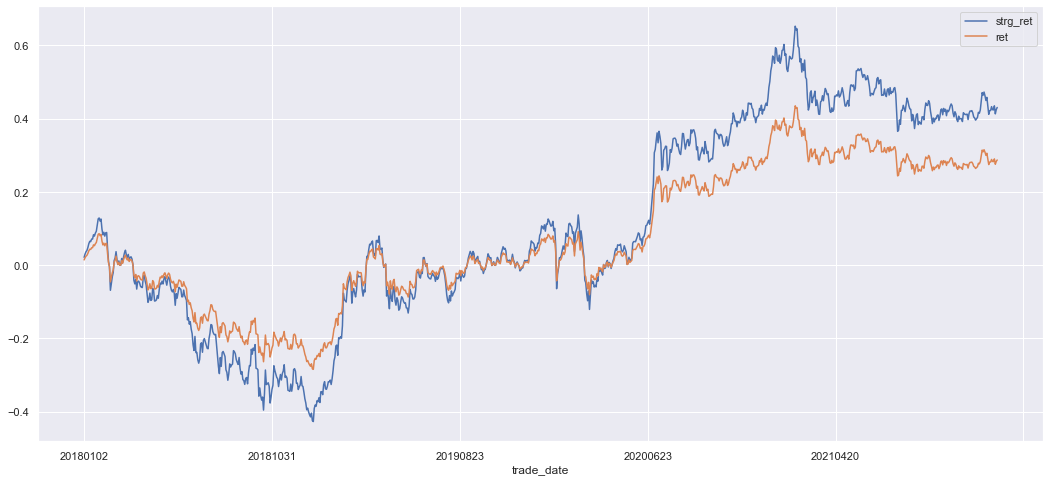

In [144]:
test_data.set_index('trade_date')[['strg_ret','ret']].cumsum().plot(figsize=(18,8),grid=True)

In [20]:
hs300 = pro.index_daily(ts_code='000050.SH', start_date='20210526', end_date='20211231').sort_values(by='trade_date')
hs300['pct_chg'] = hs300['pct_chg']/100

In [21]:
(hs300['close'].values[-1]/hs300['close'].values[0]) - 1

-0.054740138276715755

In [15]:
hs300

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
149,399300.SZ,20210526,5320.5927,5326.1169,5344.2837,5308.7389,5318.4780,2.1147,0.000398,169607096.0,346444644.7
148,399300.SZ,20210527,5338.2329,5311.3726,5378.4764,5286.0500,5320.5927,17.6402,0.003315,148462855.0,311893705.9
147,399300.SZ,20210528,5321.0886,5338.7278,5360.2774,5288.6515,5338.2329,-17.1443,-0.003212,164605806.0,330711896.3
146,399300.SZ,20210531,5331.5696,5318.0825,5331.6294,5281.6851,5321.0886,10.4810,0.001970,144603269.0,321450798.2
145,399300.SZ,20210601,5341.6798,5320.4745,5343.7529,5269.2590,5331.5696,10.1102,0.001896,143831474.0,321845842.1
...,...,...,...,...,...,...,...,...,...,...,...
4,399300.SZ,20211227,4919.3238,4918.1462,4939.6890,4894.1598,4921.3449,-2.0211,-0.000411,124100952.0,254421525.1
3,399300.SZ,20211228,4955.9644,4923.6917,4959.1448,4913.5983,4919.3238,36.6406,0.007448,130457757.0,276316732.1
2,399300.SZ,20211229,4883.4804,4958.6455,4958.6455,4883.4804,4955.9644,-72.4840,-0.014626,113587002.0,273225467.1
1,399300.SZ,20211230,4921.5109,4882.1561,4940.1780,4878.6478,4883.4804,38.0305,0.007788,121617178.0,268022477.3
